# Obtención de datos  e importación de librerías

In [ ]:
#@markdown --------------- 
#@markdown ## **⚠️❗ Ejecute esta celda para descargar genres dataset❗⚠️** 
#@markdown ### Esta celda creará la carpeta ```/content/genres_original```

!pip install -qq gdown
!gdown -qq "https://drive.google.com/u/1/uc?id=1o8RYJtI7FCdyPqbglgXf17bxajy8_CD1&export=download" -O /genres_original_short.zip
!mkdir /content/genres_original/
!unzip -qq /genres_original_short.zip -d /content/genres_original
!rm -r /genres_original_short.zip
print ("Done!")
#@markdown ---------------

Done!


In [ ]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
import tensorflow.keras as keras

from tqdm import tqdm
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Procesamiento de audio
Obtención de datos mfcc.

Para nuestros datos:

0: "disco",
1: "metal",
2: "reggae",
3: "blues",
4: "rock",
5: "classical",
6: "jazz",
7: "hiphop",
8: "country",
9: "pop"

In [ ]:
dataset_path = "/content/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
# Parámetros de configuración
n_mfcc = 13
n_fft = 2048 #tamaño de la ventana del análisis
hop_length = 512 #longitud de salto entre ventanas
num_segments = 10 #número de segmentos cada archivo de audio

# Data storage dictionary
data = {
    "mapping": [],
    "mfcc": [],
    "labels": [],
}

# Cálculo de variables auxiliares
samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
expected_vects_ps = math.ceil(samples_ps / hop_length)

def process_audio(data_path):
  # Recorrido de géneros musicales
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
      # Se asegura de no estar en la raíz
      if dirpath != data_path:
          # Guardar la etiqueta semántica
          semantic_label = os.path.basename(dirpath)
          data["mapping"].append(semantic_label)
          print(f"Processing: {semantic_label}")

          # Procesar archivos para el género específico
          for f in tqdm(filenames, ncols=80):
              if f == "jazz.00054.wav":
                  # Como librosa solo lee archivos <1Mb
                  continue
              else:
                  # Cargar el archivo de audio
                  file_path = os.path.join(dirpath, f)
                  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                  for s in range(num_segments):
                      start_sample = samples_ps * s
                      finish_sample = start_sample + samples_ps

                      # Obtener los coeficientes MFCC
                      mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                  sr=sr,
                                                  n_mfcc=n_mfcc,
                                                  hop_length=hop_length,
                                                  n_fft=n_fft)

                      mfcc = mfcc.T

                      # Guardar los coeficientes MFCC si tienen la longitud esperada
                      if len(mfcc) == expected_vects_ps:
                          data["mfcc"].append(mfcc.tolist())
                          data["labels"].append(i - 1)

process_audio(dataset_path)

# Guardar los datos en formato JSON
with open(json_path, "w") as f:
    json.dump(data, f, indent=4)

Processing: pop


100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


Processing: classical


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


Processing: blues


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Processing: disco


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


Processing: rock


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.97it/s]


Processing: country


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Processing: jazz


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Processing: metal


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


Processing: hiphop


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Processing: reggae


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


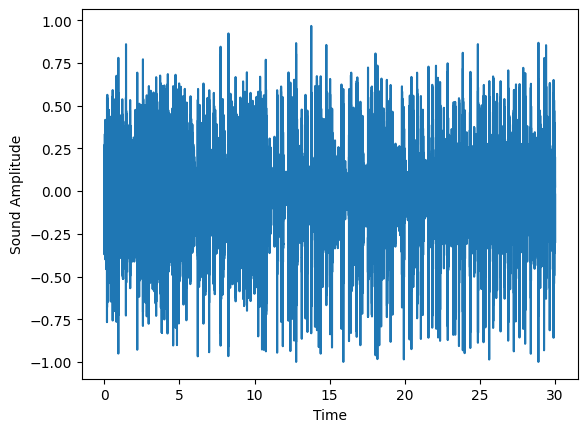

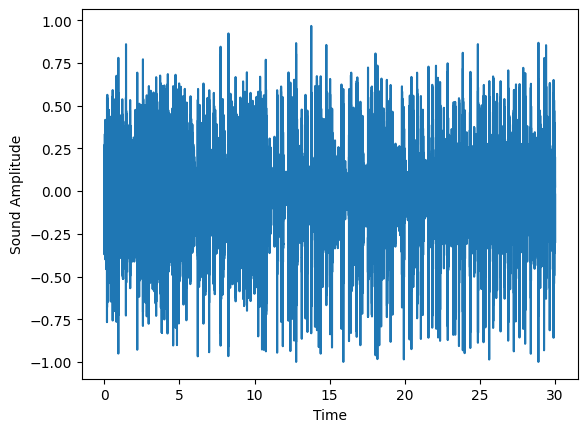

In [ ]:
for i in range(2):
    audio, sfreq = librosa.load("/content/genres_original/hiphop/hiphop.00000.wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Creación de modelo y entrenamiento
Se obtienen los datos de entrenamiento y testo y se hace el entrenamiento del modelo

In [ ]:
with open("data.json","r") as f:
    data = json.load(f)
    # Convert list to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
X_train.shape

(7988, 130, 13)

In [ ]:
# Modelo de red neuronal convolucional en Keras CNN
# RELU función de activación. valor > 0 ? valor : 0

model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = (130, 13, 1)))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [ ]:
adam = optimizers.Adam(lr=1e-4) # algortimo de optimización método de momento adaptativo y la estimación adaptativa del aprendizaje.
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",# medida de la discrepancia entre las etiquetas reales y las predicciones del modelo
              metrics=["accuracy"])

In [ ]:
hist = model.fit(X_train, y_train,\
                 epochs = 100 , batch_size = 200 , \
                    verbose = 1 , validation_split = 0.2) #se mostrará el loos y accuracy según el 20% de los datos de entrenamiento

Epoch 1/100
32/32 [==============================] - 18s 49ms/step - loss: 2.2238 - accuracy: 0.2554 - val_loss: 4.3939 - val_accuracy: 0.0964
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 1.6705 - accuracy: 0.3947 - val_loss: 3.6353 - val_accuracy: 0.1051
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 1.4435 - accuracy: 0.4789 - val_loss: 2.2678 - val_accuracy: 0.2691
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 1.2833 - accuracy: 0.5299 - val_loss: 2.1048 - val_accuracy: 0.3160
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 1.1784 - accuracy: 0.5715 - val_loss: 1.2978 - val_accuracy: 0.5332
Epoch 6/100
32/32 [==============================] - 0s 15ms/step - loss: 1.0801 - accuracy: 0.6155 - val_loss: 1.2569 - val_accuracy: 0.5375
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 1.0089 - accuracy: 0.6397 - val_loss: 1.3715 - val_accuracy: 0.5194
Epoch

# Metricas

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

63/63 [==============================] - 0s 5ms/step - loss: 1.0892 - accuracy: 0.7823
Test accuracy: 0.782282292842865


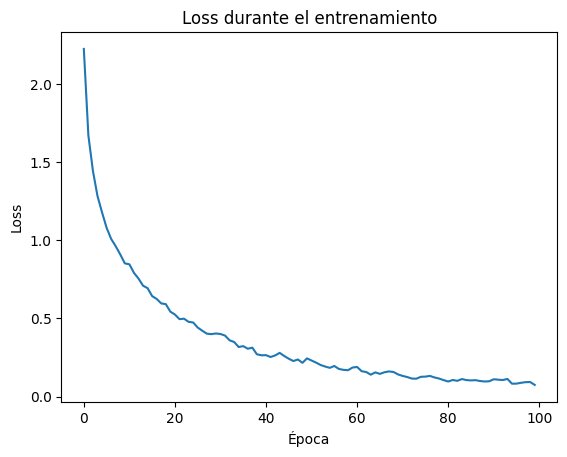

In [ ]:
# Obtener los valores de pérdida del historial de entrenamiento
loss_values = hist.history['loss']

# Crear el gráfico de la pérdida
plt.plot(loss_values)
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()

63/63 [==============================] - 0s 6ms/step


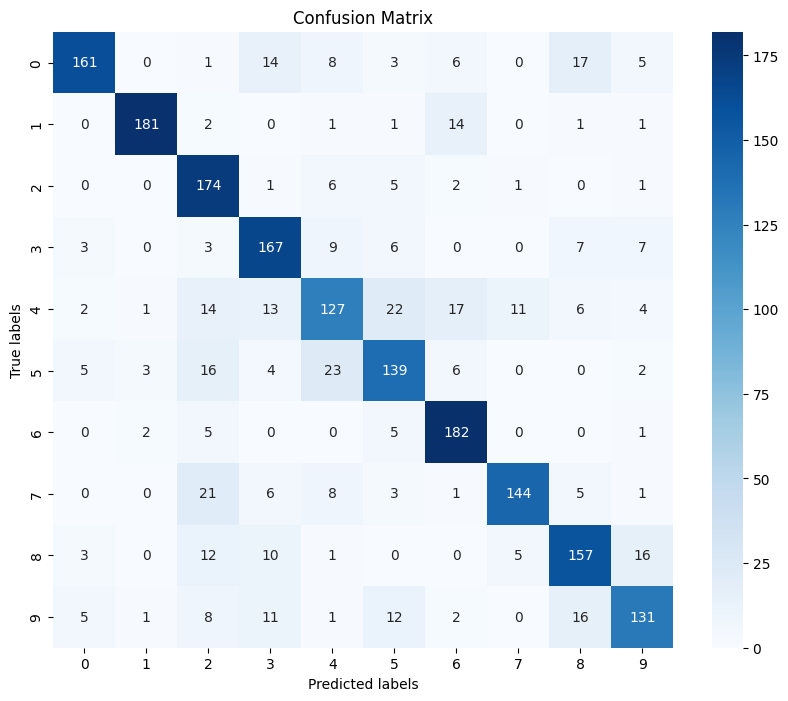

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=range(0,10), yticklabels=range(0,10))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

#0: "disco", 1: "metal", 2: "reggae", 3: "blues", 4: "rock", 5: "classical", 6: "jazz", 7: "hiphop", 8: "country", 9: "pop"